<a href="https://colab.research.google.com/github/anshumanverse/BAH_hackathon/blob/main/Untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [2]:
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.74G/2.74G [00:42<00:00, 80.7MB/s]
100% 2.74G/2.74G [00:42<00:00, 69.9MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/deepglobe-land-cover-classification-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import shutil

# Define paths
data_dir = '/content/train'
sat_image_dir = '/content/sat'
mask_image_dir = '/content/mask'

# Create directories if they don't exist
os.makedirs(sat_image_dir, exist_ok=True)
os.makedirs(mask_image_dir, exist_ok=True)

# Move files to respective directories
for filename in os.listdir(data_dir):
    if filename.endswith('_sat.jpg'):
        shutil.move(os.path.join(data_dir, filename), os.path.join(sat_image_dir, filename))
    elif filename.endswith('_mask.png'):
        shutil.move(os.path.join(data_dir, filename), os.path.join(mask_image_dir, filename))


In [5]:
sat_image_dir='/content/sat'
mask_image_dir='/content/mask'

In [6]:
import tensorflow as tf


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers, Model

In [8]:
def load_image(image_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [9]:

def load_mask(mask_path, target_size=(256, 256)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size)
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

In [10]:
def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    image = load_image(image_path, target_size)
    mask = load_mask(mask_path, target_size)
    return image, mask


In [11]:
def create_dataset(image_dir, mask_dir, batch_size):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('_sat.jpg')])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('_mask.png')])

    assert len(image_paths) == len(mask_paths), "Mismatch between number of images and masks"

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image_and_mask(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), tf.image.random_flip_left_right(y)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda x, y: (tf.image.random_flip_up_down(x), tf.image.random_flip_up_down(y)), num_parallel_calls=tf.data.experimental.AUTOTUNE)


    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [12]:

batch_size = 16
train_dataset = create_dataset(sat_image_dir, mask_image_dir, batch_size)

In [13]:
def double_conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

In [14]:
def downsample_block(x, filters):
    f = double_conv_block(x, filters)
    p = layers.MaxPooling2D(2)(f)
    return f, p



In [15]:
def upsample_block(x, conv_features, filters):
    x = layers.Conv2DTranspose(filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = double_conv_block(x, filters)
    return x

In [16]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u1 = upsample_block(bottleneck, f4, 512)
    u2 = upsample_block(u1, f3, 256)
    u3 = upsample_block(u2, f2, 128)
    u4 = upsample_block(u3, f1, 64)

    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(u4)

    model = Model(inputs, outputs)
    return model

In [17]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [18]:
epochs = 25
model.fit(train_dataset, epochs=epochs)

Epoch 1/25
51/51 [==============================] - 141s 2s/step - loss: 0.6643 - accuracy: 0.0801
Epoch 2/25
51/51 [==============================] - 84s 1s/step - loss: 0.5354 - accuracy: 0.0842
Epoch 3/25
51/51 [==============================] - 82s 1s/step - loss: 0.5325 - accuracy: 0.0842
Epoch 4/25
51/51 [==============================] - 81s 1s/step - loss: 0.5319 - accuracy: 0.0842
Epoch 5/25
51/51 [==============================] - 81s 1s/step - loss: 0.5301 - accuracy: 0.0842
Epoch 6/25
51/51 [==============================] - 80s 1s/step - loss: 0.5292 - accuracy: 0.0842
Epoch 7/25
51/51 [==============================] - 81s 1s/step - loss: 0.5300 - accuracy: 0.0842
Epoch 8/25
51/51 [==============================] - 78s 1s/step - loss: 0.5289 - accuracy: 0.0842
Epoch 9/25
51/51 [==============================] - 80s 1s/step - loss: 0.5290 - accuracy: 0.0842
Epoch 10/25
51/51 [==============================] - 82s 1s/step - loss: 0.5306 - accuracy: 0.0842
Epoch 11/25
51/51 

In [27]:
def predict_and_plot(model, image_path, target_size=(256, 256)):
    # Load and preprocess the input image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    original_size = tf.shape(image)[:2]
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the mask
    prediction = model.predict(image)
    # prediction = (prediction > 0.5).astype(np.uint8)

    # Resize the predicted mask to the original size of the input image
    prediction_resized = tf.image.resize(prediction[0], original_size)
    prediction_resized = prediction_resized.numpy()

    # Plot the input image and the predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(image).numpy())
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(image).numpy())
    plt.imshow(prediction_resized, cmap="jet", alpha=0.5)  # Overlay the mask with transparency
    plt.title("Predicted Mask on Input")
    plt.axis("off")

    plt.show()

In [28]:
test_image='/content/test/32259_sat.jpg'

1/1 [==============================] - 0s 25ms/step


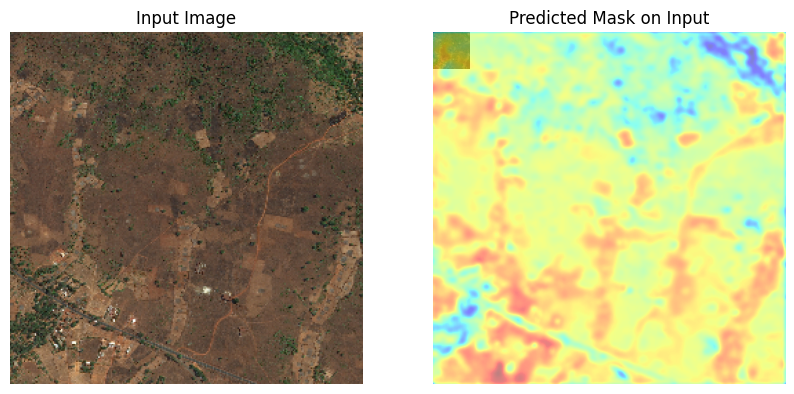

In [29]:
predict_and_plot(model,test_image)